In [10]:
%load_ext autoreload
%autoreload 2
from __future__ import print_function
from enlib import enmap
import numpy as np
from orphics import maps,io,stats,cosmology,lensing

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [23]:
shape,wcs = maps.rect_geometry(width_deg=15.0,px_res_arcmin=1.5)
shape = (3,)+shape
theory = cosmology.default_theory()
beam_arcmin = 1.5
noise_uk_arcmin = 1.0
noisep = noise_uk_arcmin * np.sqrt(2.)
flsims = lensing.FlatLensingSims(shape,wcs,theory,beam_arcmin,noise_uk_arcmin,noise_e_uk_arcmin=noisep,noise_b_uk_arcmin=noisep,pol=True,fixed_lens_kappa=None)

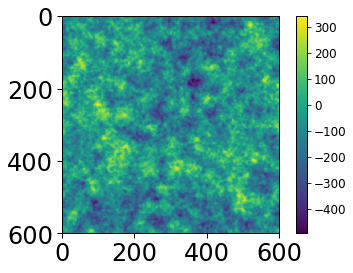

In [24]:
cmb = flsims.get_sim()
io.plot_img(cmb)

In [25]:
#n2d_beam_deconvolved = np.nan_to_num(flsims.ps_noise[0,0]/flsims.kbeam**2.)
n2d = np.nan_to_num(flsims.ps_noise[0,0])
n2p = np.nan_to_num(flsims.ps_noise[1,1])
tellmin = 300
tellmax = 3000
pellmin = 300
pellmax = 5000
kellmin = 20
kellmax = 3500
tmask = maps.mask_kspace(shape,wcs,lmin=tellmin,lmax=tellmax)
pmask = maps.mask_kspace(shape,wcs,lmin=pellmin,lmax=pellmax)
kmask = maps.mask_kspace(shape,wcs,lmin=kellmin,lmax=kellmax)

qest = lensing.qest(shape,wcs,theory,noise2d=n2d,beam2d=flsims.kbeam,kmask=tmask,noise2d_P=n2p,kmask_P=pmask,kmask_K=kmask,pol=True,grad_cut=None,unlensed_equals_lensed=True,bigell=9000)

In [26]:
Nsims = 100
fc = maps.FourierCalc(shape,wcs)
nbins = 20
bin_edges = np.linspace(kellmin,kellmax,nbins)
binner = stats.bin2D(flsims.modlmap,bin_edges)

st = stats.Stats()

for i in range(Nsims):
    unlensed,kappa,lensed,beamed,noise_map,observed = flsims.get_sim(return_intermediate=True)
    _,kmapTEB,_ = fc.power2d(observed)
    recon = qest.kappa_from_map("TT",kmapTEB[0],alreadyFTed=True)
    pcross,_,_ = fc.power2d(recon,kappa)
    reconEB = qest.kappa_from_map("EB",kmapTEB[0],kmapTEB[1],kmapTEB[2],alreadyFTed=True)
    pcrossEB,_,_ = fc.power2d(reconEB,kappa)
    pii,_,_ = fc.power2d(kappa)
    cents,p1d = binner.bin(pcross)
    cents,p1dEB = binner.bin(pcrossEB)
    cents,pii1d = binner.bin(pii)
    st.add_to_stats("ratio",(p1d-pii1d)/pii1d)
    st.add_to_stats("ratioEB",(p1dEB-pii1d)/pii1d)
    print(i)
st.get_stats()    

0
1
2
3
4
5
6
7
8
9


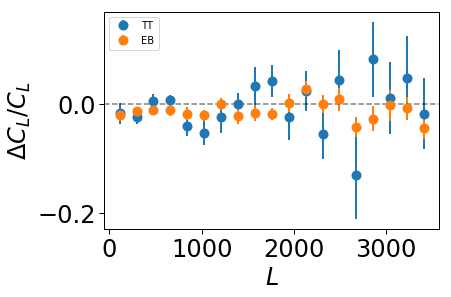

In [27]:
y = st.stats['ratio']['mean']
yerr = st.stats['ratio']['errmean']

yEB = st.stats['ratioEB']['mean']
yerrEB = st.stats['ratioEB']['errmean']


pl = io.Plotter(xlabel='$L$',ylabel='$\Delta C_L/C_L$')
pl.add_err(cents,y,yerr=yerr,marker="o",ls="none",lw=2,elinewidth=2,mew=2,markersize=8,label='TT')
pl.add_err(cents,yEB,yerr=yerrEB,marker="o",ls="none",lw=2,elinewidth=2,mew=2,markersize=8,label='EB')
pl.legend()
pl.hline()
pl.done()